In [5]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
install("pyadi_iio")

In [2]:
import adi
sdr = adi.Pluto('ip:192.168.2.1') # адрес PlutoSDR
sdr.sample_rate = int(2.5e6)
rx_data = sdr.rx()
x_real_data = []
y_imag_data = []
print("rx data length: ",len(rx_data))
for i in rx_data:
    x_real_data.append(i.real)
    y_imag_data.append(i.imag)

TypeError: argument of type 'NoneType' is not iterable

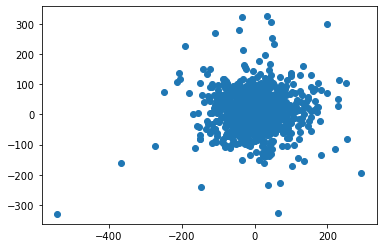

In [15]:
import matplotlib.pyplot as plt

plt.scatter(x_real_data, y_imag_data )
plt.show()